# Time Series Classification and Clustering Assignment

In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.cluster import KMeans

%matplotlib inline

### Import the Walmart stock price data set (WMT_data.csv).

In [3]:
walmart_df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')

In [4]:
walmart_df['date'] = pd.to_datetime(walmart_df['date'])

In [5]:
walmart_df = walmart_df[['date', 'close']]

### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [6]:
walmart_df['returns'] = walmart_df['close'].pct_change()

In [7]:
walmart_df['MA_5'] = walmart_df['close'].rolling(5).mean()
walmart_df['MA_10'] = walmart_df['close'].rolling(10).mean()

In [8]:
walmart_df['trend'] = 'None'
walmart_df.loc[(walmart_df['MA_5'] < walmart_df['MA_10']), 'trend'] = 'Negative'
walmart_df.loc[(walmart_df['MA_5'] > walmart_df['MA_10']), 'trend'] = 'Positive'

In [9]:
walmart_df['change'] = walmart_df['trend'].eq(walmart_df['trend'].shift())

In [10]:
walmart_df['binary'] = 0
walmart_df.loc[(walmart_df['change']==False)&(walmart_df['trend']!='None'), 'binary'] = 1 

In [11]:
walmart_df.dropna(inplace=True)
walmart_df.drop(walmart_df.index[0], inplace=True)

In [12]:
walmart_df

,date,close,returns,MA_5,MA_10,trend,change,binary
10,2013-02-25,70.44,0.000568,69.814,70.338,Negative,True,0
11,2013-02-26,71.11,0.009512,70.284,70.309,Negative,True,0
12,2013-02-27,71.66,0.007734,70.774,70.335,Positive,False,1
13,2013-02-28,70.78,-0.012280,70.878,70.274,Positive,True,0
14,2013-03-01,71.74,0.013563,71.146,70.366,Positive,True,0
...,...,...,...,...,...,...,...,...
1254,2018-02-01,105.52,-0.010131,107.558,106.612,Positive,True,0
1255,2018-02-02,104.48,-0.009856,106.776,106.601,Positive,True,0
1256,2018-02-05,100.09,-0.042018,104.884,106.065,Negative,False,1
1257,2018-02-06,100.90,0.008093,103.518,105.565,Negative,True,0


In [13]:
transformed = walmart_df[['date', 'returns', 'binary']]

history = 180
future = 0

shifts = [x + future for x in range(1, history+1)]

for shift in shifts:
  transformed[f't-{shift}'] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [14]:
transformed.head()

,date,returns,binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
190,2013-11-08,0.005806,0,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,...,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568
191,2013-11-11,0.013468,0,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,...,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512
192,2013-11-12,-0.003797,0,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,...,-0.013402,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734
193,2013-11-13,0.002414,0,-0.003797,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,...,0.007946,-0.013402,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280
194,2013-11-14,0.002281,0,0.002414,-0.003797,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,...,0.004959,0.007946,-0.013402,0.014364,-0.004087,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.01178

### Train a Logistic Regression classification model on the transformed data.

In [15]:
X = transformed.drop(['date', 'returns', 'binary'], 1)
y = transformed['binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

### Run a classification report and evaluate the performance of the classifier.

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       195
           1       0.07      0.21      0.11        19

    accuracy                           0.69       214
   macro avg       0.49      0.47      0.46       214
weighted avg       0.83      0.69      0.75       214



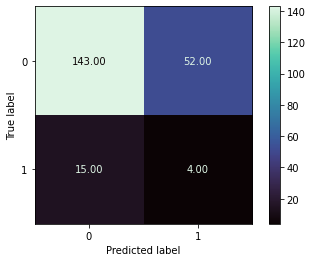

In [17]:
plot_confusion_matrix(logreg, X_test, y_test, values_format='.2f', cmap='mako')
plt.show()

### Transform the data again to have 10 days of history for clustering.

In [18]:
transformed = walmart_df[['date', 'returns', 'binary']]

history = 10
future = 0

shifts = [x + future for x in range(1, history+1)]

for shift in shifts:
  transformed[f't-{shift}'] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)

x = transformed.drop(['date', 'returns', 'binary'], 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [19]:
def kmeans(df, clusters=2):
  model = KMeans(n_clusters=clusters, random_state=42)
  clusters = model.fit_predict(df)
  results = df.copy()
  results['cluster'] = clusters

  cluster_size = results.groupby(['cluster']).size().reset_index()
  cluster_size.columns = ['cluster', 'count']
  cluster_means = results.groupby(['cluster'], as_index=False).mean()
  summary = pd.merge(cluster_size, cluster_means, on='cluster')

  return results, summary

In [20]:
summaries = {}
results = {}

for k in range(2,11):
  results[f'k_{k}'] , summaries[f'k_{k}'] = kmeans(x, clusters=k)

### Visualize the summary of the clustering results as a heatmap.

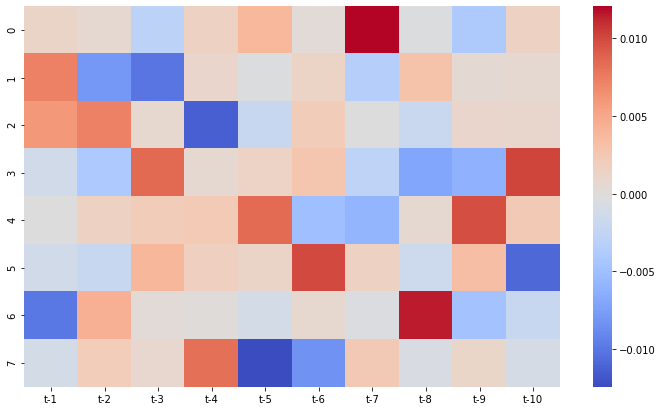

In [21]:
plt.figure(figsize=(12,7))
sns.heatmap(summaries['k_8'].drop(['cluster','count'],1), cmap='coolwarm')
plt.show()

# Lecture Notes

In [54]:
data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/NFLX_data.csv')

In [55]:
data['date'] = pd.to_datetime(data['date'])

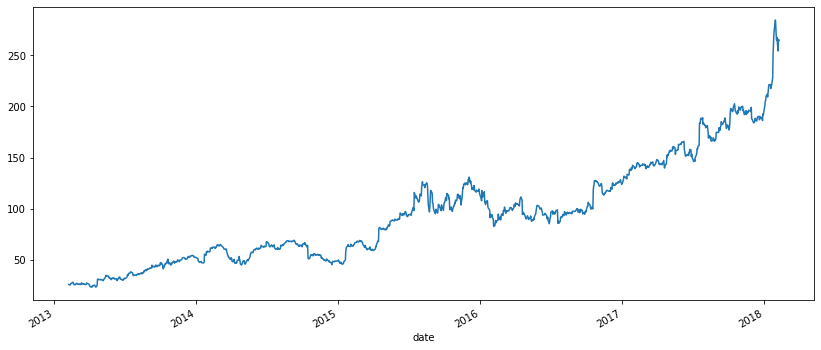

In [56]:
data.set_index('date')['close'].plot(kind='line', figsize=(14,6))

In [57]:
data['returns'] = data['close'].pct_change()

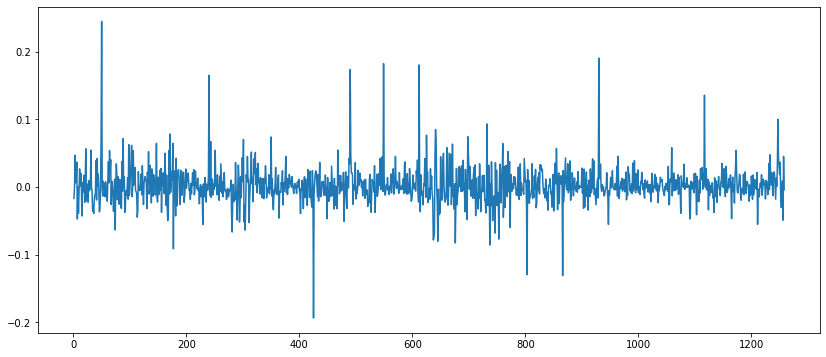

In [58]:
data['returns'].plot(kind='line', figsize=(14,6))

In [59]:
data['close'].pct_change(5) #five day return

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1254   -0.017167
1255   -0.026111
1256   -0.106574
1257   -0.046915
1258   -0.021236
Name: close, Length: 1259, dtype: float64

In [60]:
data['MA_5'] = data['close'].rolling(5).mean()
data['MA_10'] = data['close'].rolling(10).mean()

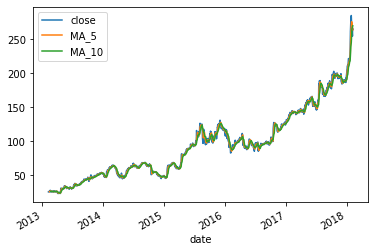

In [61]:
data.set_index('date')[['close', 'MA_5','MA_10']].plot()

In [62]:
data['trend'] = 'None'
data['trend'] = np.where((data['MA_5'] < data['MA_10']), 'Negative', 
                         np.where((data['MA_5'] > data['MA_10']), 'Positive', 
                                  'None'))

In [63]:
data['change'] = data['trend'].eq(data['trend'].shift())

In [64]:
data['binary'] = np.where(((data['change']==False)&(data['trend']!= 'None')), 1, 0)

In [71]:
data.dropna(inplace=True)
data.drop(data.index[0], inplace=True)

In [72]:
data

,date,open,high,low,close,volume,Name,returns,MA_5,MA_10,trend,change,binary
10,2013-02-25,25.8557,26.7285,25.0643,25.6171,52156104,NFLX,-0.003005,26.56856,26.41313,Positive,True,0
11,2013-02-26,25.8000,26.4600,25.0857,26.2985,33878621,NFLX,0.026599,26.21540,26.50170,Negative,False,1
12,2013-02-27,26.2257,26.5714,25.7944,26.3314,22583071,NFLX,0.001251,26.13540,26.59270,Negative,True,0
13,2013-02-28,26.2585,27.4473,26.2157,26.8685,34291733,NFLX,0.020398,26.16196,26.61857,Negative,True,0
14,2013-03-01,26.7300,27.1914,26.6014,27.0528,21448756,NFLX,0.006859,26.43366,26.64671,Negative,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2018-02-01,266.4100,271.9500,263.3800,265.0700,9669011,NFLX,-0.019349,274.67200,260.26900,Positive,True,0
1255,2018-02-02,263.0000,270.6200,262.7100,267.4300,9123610,NFLX,0.008903,273.23800,264.96600,Positive,True,0
1256,2018-02-05,262.0000,267.8990,250.0300,254.2600,11896053,NFLX,-0.049247,267.17200,267.63400,Negative,False,1
1257,2018-02-06,247.7000,266.7000,245.0000,265.7200,12595801,NFLX,0.045072,264.55600,269.17700,Negative,True,0


In [73]:
transformed = data[['date', 'returns', 'binary']]

history = 90
future = 0

shifts = [x + future for x in range(1, history+1)]

for shift in shifts:
  transformed[f't-{shift}'] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)

x = transformed.drop(['date', 'returns', 'binary'], 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [74]:
x = transformed.drop(['date', 'returns','binary'], 1)
y = transformed['binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [76]:
model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [77]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       206
           1       0.13      0.27      0.18        26

    accuracy                           0.72       232
   macro avg       0.51      0.52      0.50       232
weighted avg       0.81      0.72      0.75       232



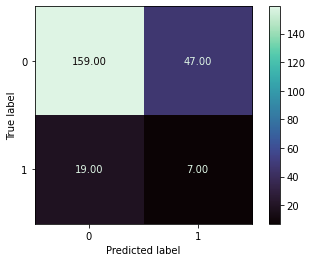

In [79]:
plot_confusion_matrix(model, x_test, y_test, values_format='.2f', cmap='mako')
plt.show()

In [80]:
transformed = data[['date', 'returns', 'binary']]

In [81]:
history = 30
future = 0

shifts = [x + future for x in range(1, history+1)]

for shift in shifts:
  transformed[f't-{shift}'] = transformed['returns'].shift(shift)

transformed.dropna(inplace=True)

x = transformed.drop(['date', 'returns', 'binary'], 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [83]:
x

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30
40,-0.009714,-0.012178,-0.017968,-0.039336,-0.031464,-0.036191,-0.005045,-0.001943,0.054319,-0.002815,-0.003789,-0.005793,0.009263,-0.022736,0.004003,-0.018688,-0.020742,0.056285,0.009201,-0.023012,0.017296,-0.007546,0.006660,0.002870,-0.043090,0.006859,0.020398,0.001251,0.026599,-0.003005
41,0.038636,-0.009714,-0.012178,-0.017968,-0.039336,-0.031464,-0.036191,-0.005045,-0.001943,0.054319,-0.002815,-0.003789,-0.005793,0.009263,-0.022736,0.004003,-0.018688,-0.020742,0.056285,0.009201,-0.023012,0.017296,-0.007546,0.006660,0.002870,-0.043090,0.006859,0.020398,0.001251,0.026599
42,-0.019426,0.038636,-0.009714,-0.012178,-0.017968,-0.039336,-0.031464,-0.036191,-0.005045,-0.001943,0.054319,-0.002815,-0.003789,-0.005793,0.009263,-0.022736,0.004003,-0.018688,-0.020742,0.056285,0.009201,-0.023012,0.017296,-0.007546,0.006660,0.002870,-0.043090,0.006859,0.020398,0.001251
43,0.041788,-0.019426,0.038636,-0.009714,-0.012178,-0.017968,-0.039336,-0.031464,-0.036191,-0.005045,-0.001943,0.054319,-0.002815,-0.003789,-0.005793,0.009263,-0.022736,0.004003,-0.018688,-0.020742,0.056285,0.009201,-0.023012,0.017296,-0.007546,0.006660,0.002870,-0.043090,0.006859,0.020398
44,0.001096,0.041788,-0.019426,0.038636,-0.009714,-0.012178,-0.017968,-0.039336,-0.031464,-0.036191,-0.005045,-0.001943,0.054319,-0.002815,-0.003789,-0.005793,0.009263,-0.022736,0.004003,-0.018688,-0.020742,0.056285,0.009201,-0.023012,0.017296,-0.007546,0.006660,0.002870,-0.043090,0.006859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-0.030488,-0.020345,0.036380,0.018168,0.032147,0.043989,0.099789,0.032296,0.000590,0.013011,-0.018192,0.001356,0.018367,0.022210,0.015336,-0.012921,0.009810,0.021203,0.002829,0.019794,0.047458,-0.003892,0.034740,-0.008095,-0.011477,0.006998,-0.001059,0.009625,-0.017855,0.001578
1255,-0.019349,-0.030488,-0.020345,0.036380,0.018168,0.032147,0.043989,0.099789,0.032296,0.000590,0.013011,-0.018192,0.001356,0.018367,0.022210,0.015336,-0.012921,0.009810,0.021203,0.002829,0.019794,0.047458,-0.003892,0.034740,-0.008095,-0.011477,0.006998,-0.001059,0.009625,-0.017855
1256,0.008903,-0.019349,-0.030488,-0.020345,0.036380,0.018168,0.032147,0.043989,0.099789,0.032296,0.000590,0.013011,-0.018192,0.001356,0.018367,0.022210,0.015336,-0.012921,0.009810,0.021203,0.002829,0.019794,0.047458,-0.003892,0.034740,-0.008095,-0.011477,0.006998,-0.001059,0.009625
1257,-0.049247,0.008903,-0.019349,-0.030488,-0.020345,0.036380,0.018168,0.032147,0.043989,0.099789,0.032296,0.000590,0.013011,-0.018192,0.001356,0.018367,0.022210,0.015336,-0.012921,0.009810,0.021203,0.002829,0.019794,0.047458,-0.003892,0.034740,-0.008095,-0.011477,0.006998,-0.001059


In [84]:
results, summary = kmeans(x, clusters=8)

In [85]:
summary

,cluster,count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30
0,0,121,0.000478,0.035462,-0.006337,0.004048,0.026123,-0.005369,-0.006166,0.016775,-0.001110,0.001303,0.001160,0.003547,0.023219,-0.003054,0.004658,0.002519,-0.000205,-0.006669,-0.000638,-0.001241,-0.003181,-0.001877,-0.000498,-0.001487,-0.004937,-0.001310,-0.004651,0.001179,-0.002416,-0.000627
1,1,372,-0.004542,-0.002270,0.001190,-0.000042,-0.000177,-0.001324,-0.004393,-0.000857,-0.004714,0.000563,0.011030,-0.001110,0.000094,0.008381,-0.004290,0.000869,0.003782,0.001779,0.001326,0.006896,0.002723,0.006970,0.004694,0.001064,-0.004371,-0.001795,-0.000761,0.000749,0.013071,0.002243
2,2,97,0.039762,-0.002692,0.004801,0.008591,0.008191,0.002498,0.004199,-0.006821,0.000839,-0.011536,-0.004454,0.016265,-0.000298,0.013633,0.024053,-0.000285,-0.003711,-0.001955,-0.005418,0.006966,0.010673,0.013147,-0.004267,-0.010267,-0.003318,-0.002845,-0.010988,-0.001837,-0.003574,0.004003
3,3,32,0.003785,0.011613,0.075174,0.011206,-0.000757,-0.001579,-0.006685,0.003745,-0.000884,0.003275,0.001790,0.005129,-0.004935,-0.004416,-0.001793,0.017455,0.057898,0.005197,0.009903,-0.005347,-0.004873,-0.000267,-0.003790,0.003957,-0.002782,0.003656,-0.000660,-0.007773,-0.002774,-0.008786
4,4,163,0.003293,-0.001016,0.002298,-0.009000,-0.006337,0.019249,-0.002092,0.007128,0.023520,0.010260,0.001056,0.012575,-0.002034,-0.002195,-0.002445,0.010111,0.000004,-0.000043,-0.000328,0.005386,-0.007174,0.002545,-0.001396,0.008218,0.002177,0.003099,0.002279,-0.008715,-0.010847,0.020204
5,5,92,-0.004033,0.000332,0.002654,0.032701,0.006743,0.009998,0.003379,0.003779,0.004573,-0.008458,0.001976,-0.003747,0.002584,0.000554,0.000726,0.008698,-0.009981,0.014570,0.028341,0.004192,-0.009200,-0.006291,-0.000166,-0.009015,0.000474,-0.003910,0.036717,-0.001403,-0.001242,-0.002312
6,6,172,-0.003142,-0.002591,-0.000470,0.000225,-0.003865,-0.001457,0.024732,0.002771,0.002434,0.008529,-0.007190,-0.001901,-0.004797,-0.002139,0.003892,0.004601,0.004241,-0.007162,0.000746,-0.002545,-0.001892,-0.000579,0.016029,-0.000001,0.026396,-0.002673,-0.001586,0.017143,-0.000948,-0.002926
7,7,170,0.005321,-0.000926,-0.001383,-0.002614,0.000011,-0.000426,0.004484,-0.002320,-0.000243,0.006165,-0.001597,-0.003102,0.004982,-0.004071,0.005719,-0.010858,-0.000917,0.015505,-0.001965,-0.007224,0.019890,-0.004933,-0.006761,0.015642,0.000875,0.021834,0.005251,0.005942,0.002051,-0.005864


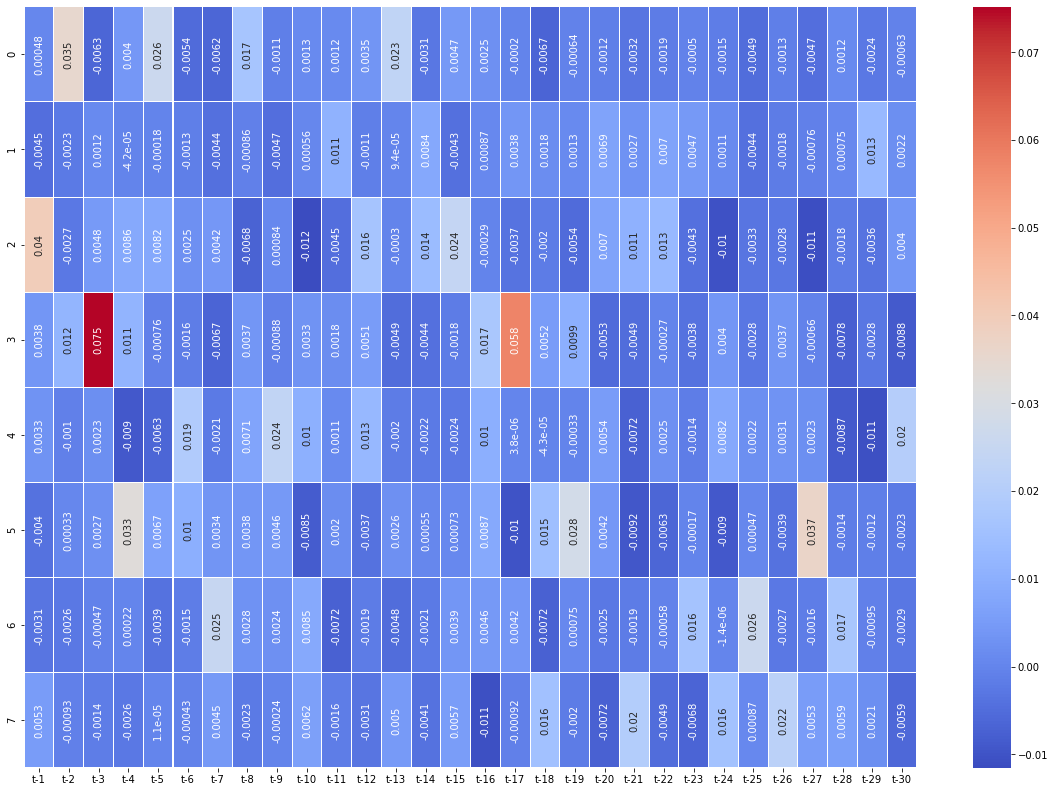

In [99]:
plt.figure(figsize=(20,14))
sns.heatmap(summary.drop(['cluster', 'count'], 1), cmap = 'coolwarm', annot=True, fmt='.2g', linewidths=0.01, annot_kws={'rotation': 90})
plt.show()

In [100]:
# https://github.com/twopirllc/pandas-ta

In [101]:
# imblearn - Oversampling, Undersampling, combination